# Assignment 2: Neural Networks

**Deadline**:  Mon 25-Nov 2019, 23:59

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.|Vien Dinh    |11002115              |viendinh17@gmail.com         |
|2.|Jorrim Prins        |11038934              |jorrim.prins@hotmail.com         |
|3.|        |              |         |

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.
3. We shall not engage in any other activities that will dishonestly improve my results or dishonestly improve or hurt the results of others.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
3. Most of your answers will consist of code. Make sure your code is well structured, efficient and provided with comments where needed. These aspects will be taken into account in the grading of your work.
4. Sometimes you are asked to explain your code or to motivate your choices. Please be concise and use your own words in answering those questions.
5. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together.

## Description
The goal of this assignment is to implement a one-hidden-layer neural network with weight decay and apply it on a simple datset.

# Generate Data
First, we initialize some libraries and generate the data.

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import accuracy_score
import pprint
pp = pprint.PrettyPrinter()

In [44]:
# Data Generating Process
def data(N=500,noise=0.1,random_state=42):
    X, t = sklearn.datasets.make_moons(n_samples=N,
                                       shuffle=True,
                                       noise=noise,
                                       random_state=random_state)
    # reshape t to a matrix T
    # reason: we want you to implement a neural network with a softmax output
    # this way your model will generalize to multiclass classification
    T = np.zeros(X.shape)
    T[:,0] = 1-t
    T[:,1] = t
    
    return X, T

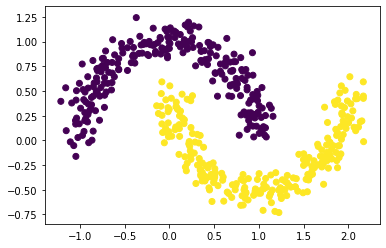

In [45]:
X, T = data()

# plot
plt.scatter(X[:,0],X[:,1],c=T[:,1])
plt.show()

Accuracy: 0.87


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


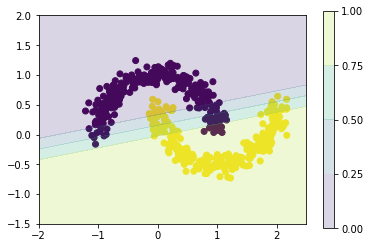

In [46]:
# Show predictions with logistic regression

# Make prediction mesh
x1_mesh, x2_mesh = np.meshgrid(np.linspace(-2, 2.5, 100), 
                               np.linspace(-1.5, 2, 100))
X_mesh = np.array([x1_mesh, x2_mesh]).reshape(2, -1).T

# Predict (set C (inverse of alpha) very high to effectively have no regularization)
clf = sklearn.linear_model.LogisticRegression(C=1e8).fit(X,T[:,1])
Y_mesh = clf.predict_proba(X_mesh)

# accuracy
y = clf.predict(X)
acc = accuracy_score(T[:,1],y)
print(f'Accuracy: {acc:.2f}')

# Plot
plt.scatter(X[:, 0], X[:, 1], c=T[:,1]) 
plt.contourf(x1_mesh, x2_mesh, Y_mesh[:,1].reshape(100, 100), # the mesh
             np.linspace(0, 1, 5), alpha=0.2) # the bar at the right
             
plt.colorbar()
plt.xlim(-2, 2.5)
plt.ylim(-1.5, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Neural Network Model

In this assignment you are going to implement a neural network model from scratch.
We will follow the notation of Bishop with a few exceptions:

![NNet](./img/nnet_bishop_fig51.png)

The model you will implement has:

* 500 observations ($N=500$), which are the rows of $\mathbf{X}$ $(N \times D)$ and $\mathbf{T}$ $(N \times K)$
* Two inputs ($D=2$), which are the columns of $\mathbf{X}$ respectively
* One hidden layer ($M$ nodes), with a tanh activation function
* Two outputs ($K=2$): which are the columns of $\mathbf{T}$ respectively
* The final layer will have a softmax activation function (do **NOT** simplify to a sigmoid with K=1)

In contrast to Bishop we will use a vectorized notation, which leverages the [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) concept of numpy:

$$\mathbf{Y} = softmax((tanh(\mathbf{XW^{(1)}+b^{(1)})W^{(2)} + b^{(2)}})$$

Where:

* tanh is applied element-wise to a matrix
* softmax is applied row-wise to a matrix
* $\mathbf{b^{(1)}}$ is vector of length $M$, and $\mathbf{b^{(2)}}$ is similarly defined
* the addition of the bias vectors is applied per row

You'll notice this representation is more convenient when implementing a neural network in practice.



**Exercise 1** (1 point) Code function <span style="color:blue">init_params()</span> that takes the dimensions of the layers and returns randomly (standard normal) initialized weight matrices and zero-value initialized bias vectors.

In [47]:
# Exercise
def init_params(D,M,K):
    """
    Purpose:
        Returns the weight matrices and bias vectors for both layers:
            Weight matrices are randomly initialized (standard normal distribution)
            Bias vectors are intialized with zeros
    Inputs:
        D   integer, number of feature inputs
        M   integer, number of hidden nodes
        K   integer, number of classes
    Output:
        params   disctionary of initial weights: 
                 W1  (D,M) matrix
                 b1  (M,) vector
                 W2  (M,K) matrix
                 b2  (K,) vector
    """
    
    ### START CODE HERE ###
    b1 = np.zeros(M)
    b2 = np.zeros(K)
    W1 = np.random.standard_normal((D,M))
    W2 = np.random.standard_normal((M,K))
    

    ### END CODE HERE ###
    
    params = {'W1':W1,
              'b1':b1,
              'W2':W2,
              'b2':b2}
    
    return params

In [48]:
np.random.seed(42)
params = init_params(2,3,2)

pp.pprint(params)

{'W1': array([[ 0.49671415, -0.1382643 ,  0.64768854],
       [ 1.52302986, -0.23415337, -0.23413696]]),
 'W2': array([[ 1.57921282,  0.76743473],
       [-0.46947439,  0.54256004],
       [-0.46341769, -0.46572975]]),
 'b1': array([0., 0., 0.]),
 'b2': array([0., 0.])}


**Exercise 2** (2 points) Code function <span style="color:blue">predict()</span> that takes input X and parameters dictionary *params* and returns the predicted probabilities of T, and a dictionary of all interim values (see code).

In [49]:
# you may use sklearns implementation of the softmax function
from sklearn.utils.extmath import softmax

In [50]:
def predict(X,params):
    """
    Purpose:
        Makes a prediction with the neural network
    Inputs:
        X        (N,D) matrix, features data
        params   dictionary of parameters: {'W1','b1','W2','b2'}
    Output: 
        Y        (N,D) matrix, predicted probabilities
        interim  dictionary of intermediate values:{'A1','Z1','A2','Z2'}
    """
    # unpack dictionary
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    A1 = X@W1 + b1
    Z1 = np.tanh(A1)
    A2 = Z1@W2 + b2
    Z2 = softmax(A2)
    Y= Z2
    
    
    interim = {'A1':A1,
               'Z1':Z1,
               'A2':A2,
               'Z2':Z2}
    
    return Y, interim

In [51]:
Y, interim = predict(X,params)
print(Y[0:3,:])

[[0.46282556 0.53717444]
 [0.74231061 0.25768939]
 [0.4650551  0.5349449 ]]


**Exercise 3** (2 points) Code function <span style="color:blue">gradient()</span> that takes input X, output T, *params*, and *interim* and return the gradients of of the cross entropy loss (defined below) with respect to the parameters.

$$CELoss = \frac{1}{N} \sum_{n=1}^N \sum_{k=1}^K t_{n,k} \log y_{n,k}$$

In [52]:
# you may use sklearns implementation of the cross entropy loss:
from sklearn.metrics import log_loss

In [53]:
def gradient(params, interim, X, T):
    """
    Purpose:
        Get gradients for params
    Inputs:
        params   dictionary of parameters: {'W1','b1','W2','b2'}
        interim  dictionary of intermediate values:{'A1','Z1','A2','Z2'}
        X        (N,D) matrix, features data
        T        (N,K) matrix, target data
    Outputs:
        grads    dictionary of gradients
    """
    N = X.shape[0]
    
    # unpack dictionary
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
    
    A1 = interim['A1']
    A2 = interim['A2']
    Z1 = interim['Z1']
    Z2 = interim['Z2']
    
    dW2 = (1/N)*Z1.T@(Z2 - T)
    db2 = np.mean((Z2 - T), axis=0)
    dW1 = (1/N)*((((Z2 - T)@W2.T)*(1-Z1**2)).T@X).T
    db1 = np.mean((((Z2 - T)@W2.T)*(1-Z1**2)), axis=0)

    # store into dictionary
    grads = {'W1':dW1,
             'b1':db1,
             'W2':dW2,
             'b2':db2,
            }
    
    return grads

**Exercise 4** (2 points) Code function <span style="color:blue">update()</span>, it should incorporate a learning rate and weight decay. For details on weight decay see: Computer Lab 3, Bishop Section 3.1.4 and the beginning of Section 5.5.

In [54]:
def update(params,grads, eta, wd):
    """
    Purpose:
        Update all parameters based on SGD with l2 regularization/weight decay
    Inputs:
        params    dictionary of parameters
        grads     dictionary of gradients
        eta       double, learning rate
        wd        double, weight decay/regularization parameter
    Outputs:
        params    dictionary of updated parameters
    """
    
    for i in params.keys():
        params[i] = params[i] - eta*(grads[i] + wd*params[i])

    return params

In [55]:
np.random.seed(42)
params = init_params(2,3,2)
Y, interim = predict(X,params)
grads = gradient(params, interim, X, T)

eta = 0.05
wd = 0.07
upd = update(params,grads, eta, wd)
pp.pprint(upd)

{'W1': array([[ 0.4861068 , -0.12176704,  0.64540645],
       [ 1.52069133, -0.23941333, -0.23330648]]),
 'W2': array([[ 1.57432969,  0.76410459],
       [-0.46699483,  0.53982469],
       [-0.4710884 , -0.45480703]]),
 'b1': array([-4.51467179e-03,  5.36690448e-03, -3.75847480e-06]),
 'b2': array([-0.00550632,  0.00550632])}


**Exercise 5** (2 points) Code function <span style="color:blue">model()</span> which puts it all together and lets the user train a multiclass classification problem with a one hidden layer neural network with $M$ nodes for a certain number of epochs, with a particular learning rate, and weight decay.

In [35]:
def model(X,T,M,epochs,eta,wd,verbose=True):
    """
    Purpose:
        Estimates a neural network model with one hidden layer
    Inputs:
        X      (N,D) matrix, input values
        T      (N,K) matrix, target data
        M      integer, number of hidden nodes
        epochs integer, number of epochs
        eta    double, learning rate
        wd     double, weight decay/regularization parameter
    Outputs:
        params  dictionary of parameters
    """
    np.random.seed(42)

    # get dims
    N = X.shape[0]
    D = X.shape[1]
    K = T.shape[1]
    
    # init params
    params = init_params(D, M, K)
    # for loop over epochs
    for i in range(epochs):
        # predict
        Y, interim = predict(X, params)
        # loss
        loss = log_loss(T, Y)
        # gradient
        grads = gradient(params, interim, X, T)
        # update
        params = update(params, grads, eta, wd)
    
        # print
        if verbose and i % 1000 == 0:
            print(f'epoch {i} -- loss: {loss:.2f}')
            
    return params

**Exercise 6** (1 point) 

Now let us train a neural network on a different scenario with a noisier dataset and more nodes in the hidden layer.
Furthermore you will train two neural networks: one without weight decay and one with weight decay of $0.005$.
Take a look at the output below and answer the following question:

**Why is the accuracy better for the high weight decay scenario, while the loss is better for the training case scenario?**


Weight decay simply adds a certain penalty for the value of de weight parameters. This penalty is added to the loss function and, as some parameters will be larger than 0, the loss in the **WD = 0.005** scenario will be higher than in the **WD = 0.000** scenario (looking at training set loss). 

However, the accuracy is better for the **WD = 0.005** scenario, because the weight decay parameter shrinks the weight parameters. This protects the model from overfitting and increases the generalization property of the model (accuracy on the test set increases).


| |**0.000**|**0.005**|
|--|--------|--------------|
|Loss|0.34    |0.36              |
|Accuracy|0.82        |0.84              |





Weight decay = 0.0
epoch 0 -- loss: 0.71
epoch 1000 -- loss: 0.35
epoch 2000 -- loss: 0.35
epoch 3000 -- loss: 0.34
epoch 4000 -- loss: 0.34
Loss on test set: 0.3714867902855172

Weight decay = 0.005
epoch 0 -- loss: 0.71
epoch 1000 -- loss: 0.36
epoch 2000 -- loss: 0.36
epoch 3000 -- loss: 0.36
epoch 4000 -- loss: 0.36
Loss on test set: 0.36491276633592984


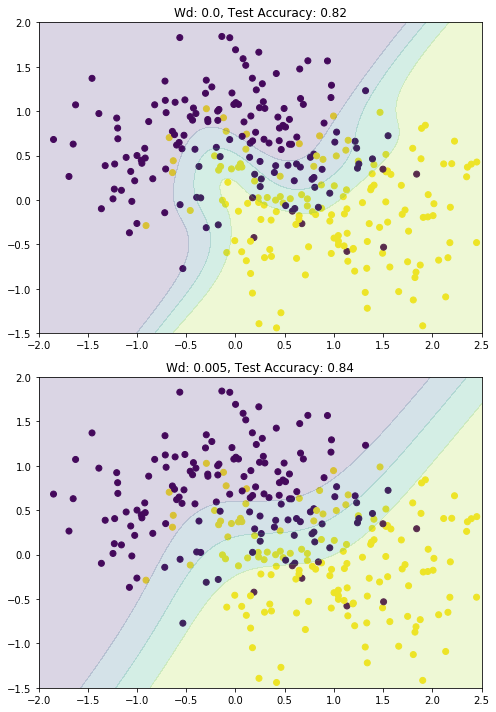

In [42]:
# Show predictions with neural net

# create train and test set
X_train,T_train = data(N=300,noise=0.45,random_state=42)
X_test,T_test = data(N=1000,noise=0.45,random_state=43)

weight_decays = [0.0,0.005]

fig = plt.figure(figsize=(7,10))
i =0

for weight_decay in weight_decays:  
    i+=1
    print(f'\nWeight decay = {weight_decay}')
    # train
    params = model(X_train,T_train,
                   M=40,
                   epochs=5000,
                   eta=0.05,
                   wd=weight_decay,
                   verbose=True,
                  )

    # Make prediction mesh
    x1_mesh, x2_mesh = np.meshgrid(np.linspace(-2, 2.5, 100), 
                                   np.linspace(-1.5, 2, 100))
    X_mesh = np.array([x1_mesh, x2_mesh]).reshape(2, -1).T

    # Predict
    Y_mesh,_ = predict(X_mesh,params)

    # accuracy
    Y_test,_ = predict(X_test,params)
    print('Loss on test set:', log_loss(T_test[:,1],Y_test[:,1]))
    acc = accuracy_score(T_test[:,1],Y_test[:,1]>0.5)

    # Plot
    ax = fig.add_subplot(2,1,i)
    ax.set_title(f'Wd: {weight_decay}, Test Accuracy: {acc:.2f}')
    ax.scatter(X_train[:, 0], X_train[:, 1], c=T_train[:,1]) 
    ax.contourf(x1_mesh, x2_mesh, Y_mesh[:,1].reshape(100, 100), # the mesh
                 np.linspace(0, 1, 5), alpha=0.2) # the bar at the right
                 
    ax.set_xlim(-2,2.5)
    ax.set_ylim(-1.5, 2)
    
fig.tight_layout()

